In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_5_features = pd.read_excel('data-5features-all-outputs.xlsx')
df_30_features = pd.read_excel('data-30-features-all-outputs.xlsx')
df_all_features = pd.read_excel('All_data_correct.xlsx')
df_all_features.drop(columns=["Responsibility", "Listening_skills", "Questioning_skills", "Team_participation", "Teamwork_oriented"], inplace=True)
df_5_features = df_5_features.iloc[:,2:]
df_all_features = df_all_features.iloc[:, 2:]

numerical_features = df_all_features.iloc[:, 7:]
numerical_features_names = list(df_all_features.iloc[:, 7:])

# Normalisation of the data
df_all_features[numerical_features_names] = (numerical_features - numerical_features.min())/(numerical_features.max()-numerical_features.min())

Previous research have only implemented regression analysis with neuroticism and each output feature of team climate. They have selected neuroticism because was the only personality variable that demonstrated high correlation between neuroticism and team climate variables

In [103]:
df_30_features

,Friendliness,Gregariousness,Assertiveness,Activity Level,Excitement-Seeking,Cheerfulness,Trust,Morality,Altruism,Cooperation,...,Artistic Interests,Emotionality,Adventurousness,Intellect,Liberalism,Vision,Task_Orientation,Support_for_innovation,Participative_safety,Team_Climate
0,56,87,25,18,84,46,61,81,95,87,...,40,75,78,79,71,4.000000,5.000000,4.750,4.833333,4.605
1,20,11,1,47,41,3,65,74,54,32,...,16,75,53,10,49,4.000000,4.428571,4.000,4.583333,4.263
2,88,80,54,49,46,76,92,72,45,35,...,3,43,1,18,53,4.818182,5.000000,5.000,5.000000,4.947
3,88,46,63,49,36,96,99,61,95,63,...,40,13,58,87,53,4.818182,4.857143,3.875,5.000000,4.684
4,76,69,64,59,38,71,52,78,49,37,...,71,58,24,70,69,4.000000,4.142857,3.750,3.833333,3.921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,37,29,54,49,17,27,9,81,57,44,...,69,32,19,48,62,4.818182,5.000000,5.000,4.833333,4.830
278,13,4,25,70,1,18,70,39,33,54,...,31,22,11,59,79,3.636364,3.428571,4.250,3.750000,3.770
279,88,29,81,60,56,76,51,50,13,35,...,8,13,28,18,62,4.727273,3.285714,3.125,3.750000,3.720
280,74,64,25,49,56,57,32,72,57,54,...,40,13,11,27,43,4.363636,4.285714,4.125,4.000000,4.260


In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

df_new = df_30_features.copy()
outputs = ['Vision', 'Task_Orientation', 'Support_for_innovation', 'Participative_safety', 'Team_Climate']
# Remove the target column from the features
X = df_new.drop(columns=outputs)
# Set y variable
y = df_new[['Team_Climate']]

scaler = StandardScaler()
# Standardize the X variables
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Instantiate the Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

In [105]:
X_scaled

array([[-0.02009282,  1.40685952, -0.74412678, ...,  1.33717397,
         1.65150543,  0.72569136],
       [-1.44654223, -1.22579683, -1.68058085, ...,  0.39361712,
        -1.01485639, -0.35164513],
       [ 1.24786222,  1.16437801,  0.3874219 , ..., -1.56898113,
        -0.70571299, -0.15576577],
       ...,
       [ 1.24786222, -0.60227296,  1.44093274, ..., -0.54993973,
        -0.70571299,  0.2849628 ],
       [ 0.69313189,  0.61013457, -0.74412678, ..., -1.19155839,
        -0.35792667, -0.64546418],
       [ 1.24786222,  1.40685952, -0.3929565 , ..., -0.8896202 ,
         1.65150543,  1.50920882]])

In [106]:
print("Train data:")
r_sq = model.score(X_train, y_train)
print('Coefficient of determination:', r_sq)
y_pred_train = model.predict(X_train)
print('R^2:', r2_score(y_train, y_pred_train))
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))

Train data:
Coefficient of determination: 0.1869590191265771
R^2: 0.1869590191265771
MAE: 0.4074135652139651
MSE: 0.2829182430464068
RMSE: 0.5319005950799517


In [107]:
print("Test data:")
r_sq_test = model.score(X_test, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = model.predict(X_test)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Test data:
Coefficient of determination: -0.0842874379079992
R^2: -0.0842874379079992
MAE: 0.49177919026578665
MSE: 0.45035422658651053
RMSE: 0.6710843662212006


In [108]:
results = pd.DataFrame(data={'actual': y_test['Team_Climate'],
                             'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
118,4.68,4.354451,0.325549
64,3.88,4.223377,-0.343377
90,2.86,4.069741,-1.209741
201,4.39,4.181288,0.208712
273,4.18,4.079451,0.100549


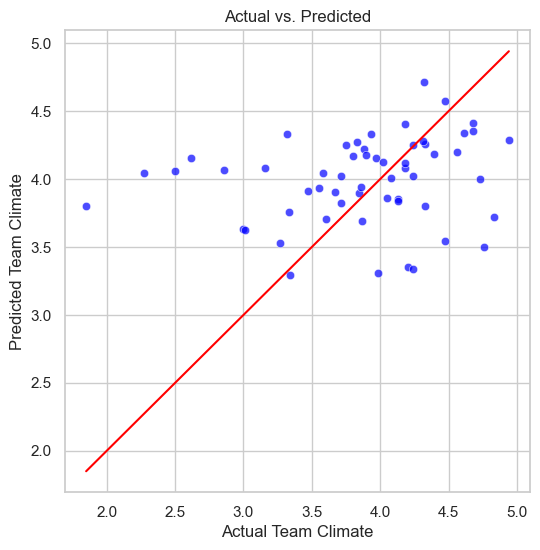

In [110]:
# Set plot style
sns.set(style='whitegrid')

# Create scatterplot
plt.figure(figsize=(6, 6))
sns.scatterplot(x='actual', y='predicted', data=results, color='blue', alpha=0.7)

# Add a diagonal line for reference
sns.lineplot(x=results['actual'], y=results['actual'], color='red')

# Set plot title and labels
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Team Climate')
plt.ylabel('Predicted Team Climate')

plt.savefig('./images/linealRegWithout.png')
# Show the plot
plt.show()

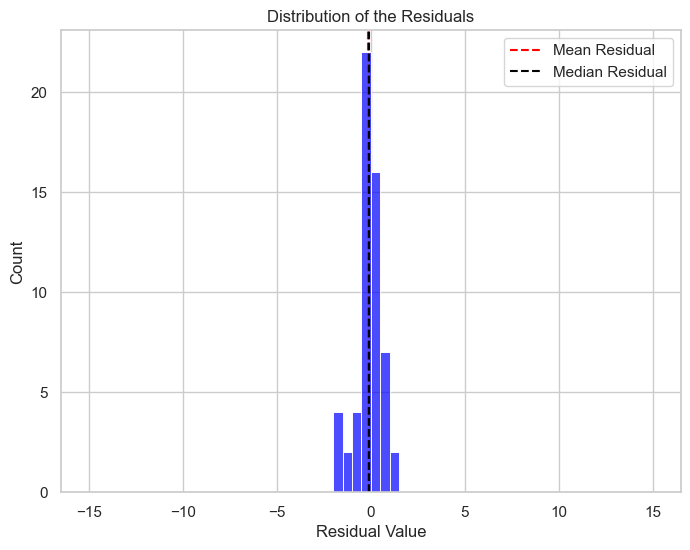

In [111]:
# Set plot style
sns.set(style='whitegrid')

# Create histogram
plt.figure(figsize=(8, 6))
sns.histplot(results['residual'], bins=np.arange(-15, 15.5, 0.5), color='blue', alpha=0.7)

# Add vertical lines for mean and median
mean_residual = results['residual'].mean()
median_residual = results['residual'].median()
plt.axvline(x=mean_residual, color='red', linestyle='--', label='Mean Residual')
plt.axvline(x=median_residual, color='black', linestyle='--', label='Median Residual')

# Set plot title and labels
plt.title('Distribution of the Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Count')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [112]:
# Calculate residual mean
residual_mean = results['residual'].mean()
residual_mean

-0.1199100315052511

Text(0, 0.5, 'Residuals')

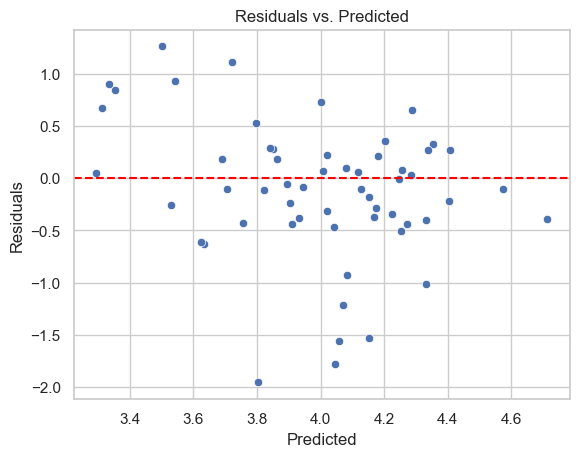

In [113]:
# Create a scatterplot of `residuals` over `predicted`
sns.scatterplot(x=results['predicted'], y=results['residual'])
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

In [114]:
coefficients = pd.DataFrame(model.coef_, columns=X.columns)
coefficients

,Friendliness,Gregariousness,Assertiveness,Activity Level,Excitement-Seeking,Cheerfulness,Trust,Morality,Altruism,Cooperation,...,Depression,Self-Consciousness,Immoderation,Vulnerability,Imagination,Artistic Interests,Emotionality,Adventurousness,Intellect,Liberalism
0,0.101463,0.043768,-0.087452,-0.058025,-0.002869,0.035783,0.092035,-0.019823,-0.064231,0.065021,...,0.065493,0.059016,-0.036123,-0.0588,0.051839,-0.049531,0.014642,-0.077144,0.049337,-0.03801
